**WIC 2017-07-25** - hacked out of Peter Yoachim's **CrowdingMetrics.ipynb** to assemble crowding limiting magnitudes and m5coadd for each filter.

We now have metrics that use the stellar luminosity function maps to compute the errors that will result from stellar crowding.

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

In [246]:
# pieces we need to extract spatial information
import healpy as hp
import healpyUtils
import numpy as np

In [247]:
# astropy manipulation
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u

In [248]:
# does runcompare work?
from lsst.sims.maf.viz import MafRunComparison

In [249]:
# Set up the database connection
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
outDir = 'crowding_test_2017-07-25'
resultsDb = db.ResultsDb(outDir=outDir)
#nside = 64

For the CrowdingMetric, one sets the acceptable magnitude uncertainty, and the metric finds the magnitude star that will have that uncertainty given the crowding.  

In [250]:
thisFilter = 'r'
nside = 64
tMax = 730

In [251]:
bundleList = []
metric = metrics.CrowdingMetric(crowding_error=0.05, seeingCol='FWHMeff')

In [252]:
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
sql = 'filter="%s" and night < %i' % (thisFilter, tMax)
plotDict={'colorMax':27.}
bundle = metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict)
bundleList.append(bundle)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [253]:
# Also take the seeing and the per-exposure m5col
summaryStats = [metrics.MedianMetric(), metrics.RmsMetric(), metrics.RobustRmsMetric()]

In [254]:
# take the coadded depth as a second metric
metricCoadd = metrics.Coaddm5Metric()
bundleCoadd = metricBundles.MetricBundle(metricCoadd,slicer,sql,plotDict=plotDict)
bundleList.append(bundleCoadd)

In [255]:
# SEEING information...
plotDictSeeing = {'colorMax':2.}
metricSeeing = metrics.MedianMetric(col='FWHMeff')
bundleSeeing = metricBundles.MetricBundle(metricSeeing,slicer,sql,plotDict=plotDictSeeing)
bundleList.append(bundleSeeing)

# ditto its standard deviation
plotDictSeeingRMS = {'colorMax':1.}
metricSeeingRMS = metrics.RobustRmsMetric(col='FWHMeff')
bundleSeeingRMS = metricBundles.MetricBundle(metricSeeingRMS,slicer,sql,plotDict=plotDictSeeingRMS)
bundleList.append(bundleSeeingRMS)

In [256]:
# Per-exposure M5 depth...
plotDictM5 = {'colorMax':26}
metricM5 = metrics.MedianMetric(col='fiveSigmaDepth')
bundleM5 = metricBundles.MetricBundle(metricM5, slicer, sql, plotDict=plotDictM5)
bundleList.append(bundleM5)

plotDictM5RMS = {'colorMax':1}
metricM5RMS = metrics.RobustRmsMetric(col='fiveSigmaDepth')
bundleM5RMS = metricBundles.MetricBundle(metricM5RMS, slicer, sql, plotDict=plotDictM5RMS)
bundleList.append(bundleM5RMS)


In [257]:
# airmass
plotDictZ = {'colorMax':3}
metricZ = metrics.MedianMetric(col='airmass')
bundleZ = metricBundles.MetricBundle(metricZ, slicer, sql, plotDict=plotDictZ)
bundleList.append(bundleZ)

plotDictZRMS = {'colorMax':1}
metricZRMS = metrics.RobustRmsMetric(col='airmass')
bundleZRMS = metricBundles.MetricBundle(metricZRMS, slicer, sql, plotDict=plotDictZ)
bundleList.append(bundleZRMS)

In [258]:
# and nvisits
metricN = metrics.CountMetric(col='fiveSigmaDepth')
bundleN = metricBundles.MetricBundle(metricN, slicer, sql)
bundleList.append(bundleN)

In [259]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Querying database with constraint filter="r" and night < 730
Found 91416 visits
Running:  ['opsim_Crowding_To_Precision_r_and_night_lt_730_HEAL', 'opsim_Median_FWHMeff_r_and_night_lt_730_HEAL', 'opsim_RobustRms_FWHMeff_r_and_night_lt_730_HEAL', 'opsim_Median_fiveSigmaDepth_r_and_night_lt_730_HEAL', 'opsim_Count_airmass_r_and_night_lt_730_HEAL', 'opsim_Median_airmass_r_and_night_lt_730_HEAL', 'opsim_CoaddM5_r_and_night_lt_730_HEAL', 'opsim_RobustRms_airmass_r_and_night_lt_730_HEAL', 'opsim_RobustRms_fiveSigmaDepth_r_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r" and night < 730" constraint now.
Plotting complete.


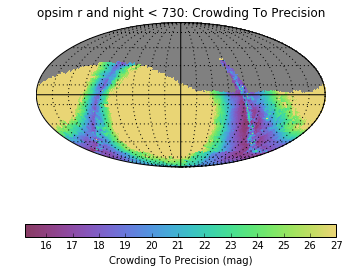

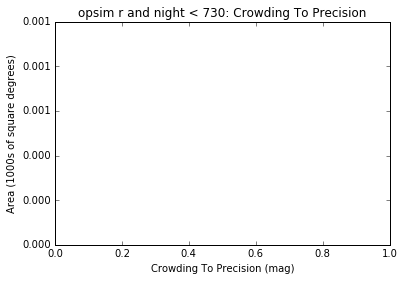

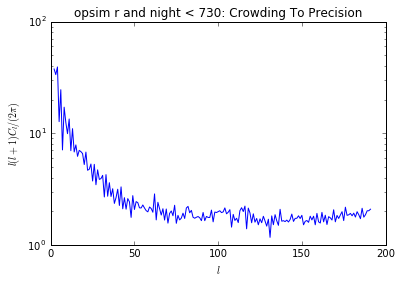

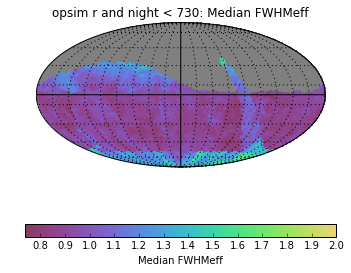

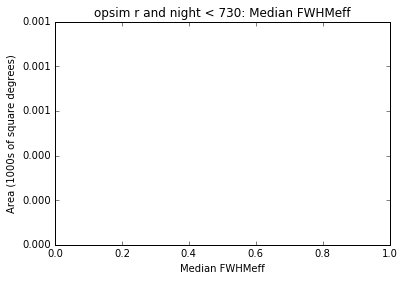

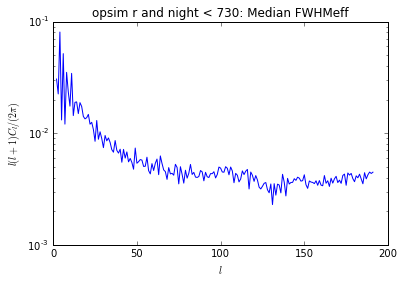

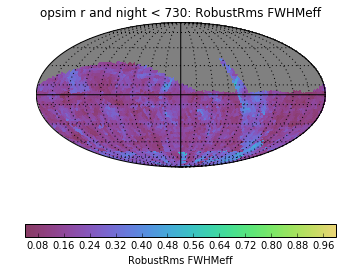

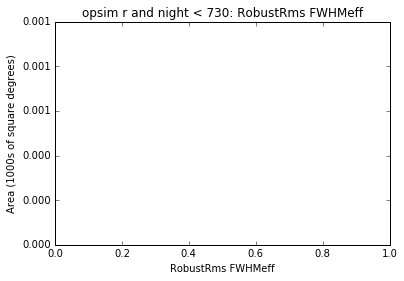

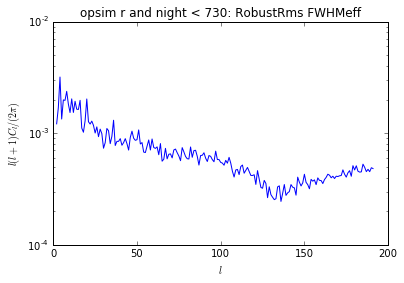

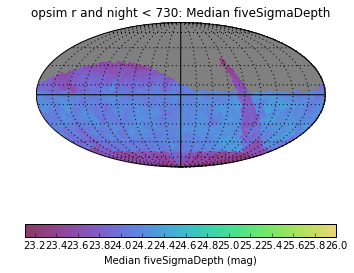

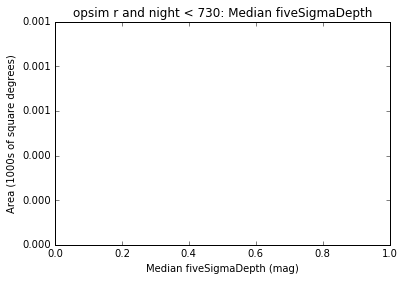

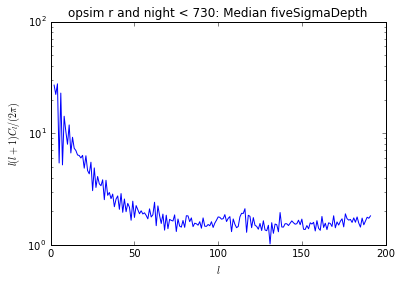

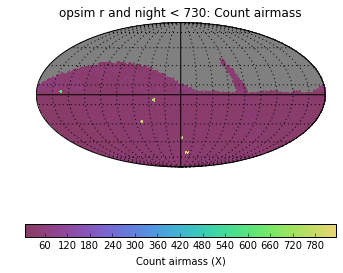

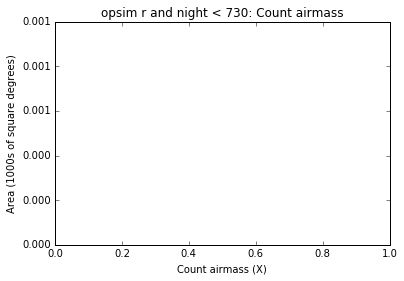

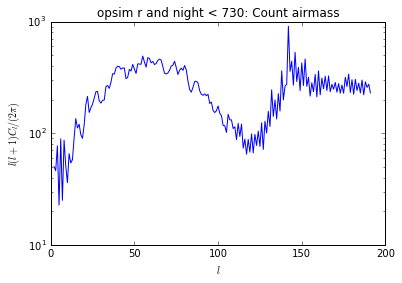

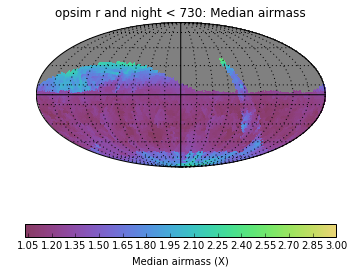

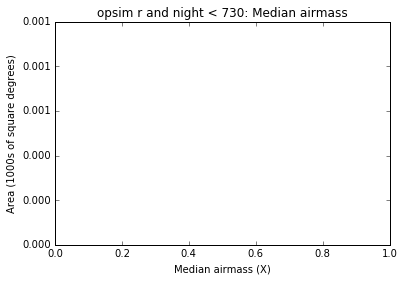

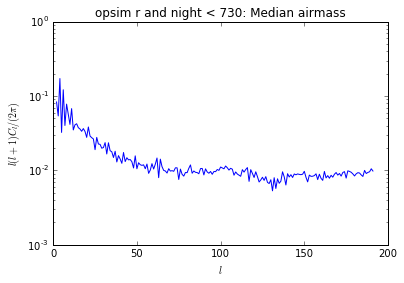

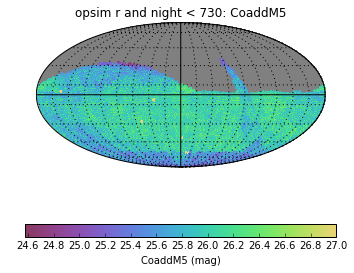

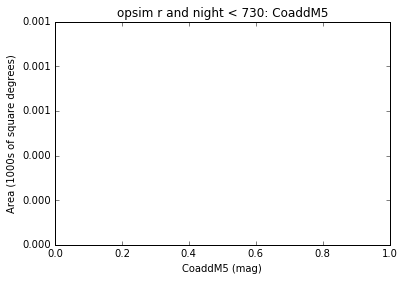

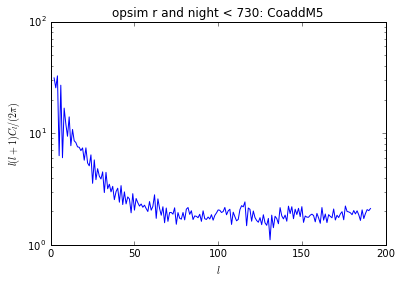

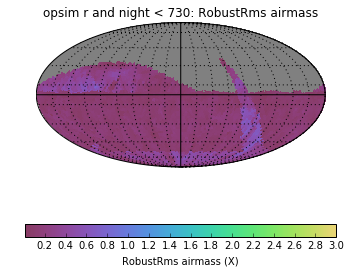

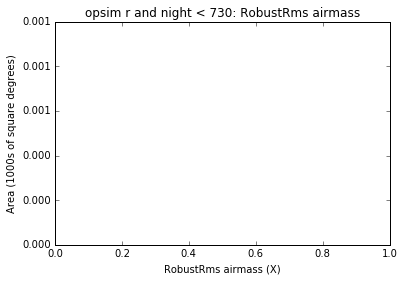

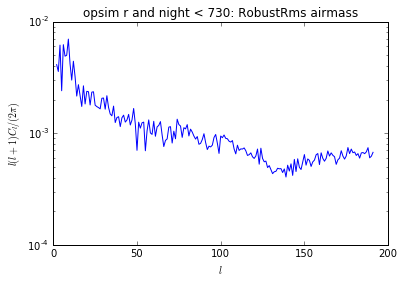

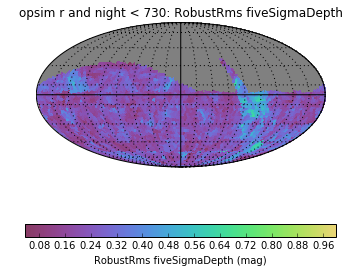

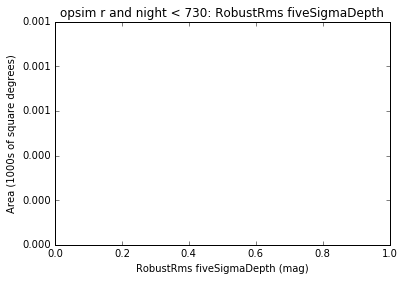

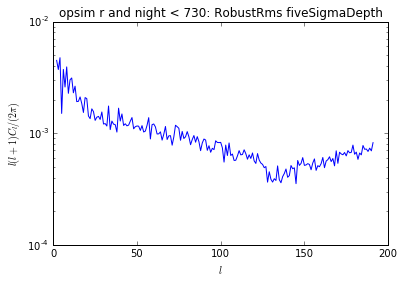

In [260]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

### Accessing the values we've just produced ###

In [261]:
# names of bundles for easier retrieval
nameDepth = 'opsim_CoaddM5_%s_and_night_lt_%i_HEAL' % (thisFilter, tMax)
nameCrowd = 'opsim_Crowding_To_Precision_%s_and_night_lt_%i_HEAL' % (thisFilter, tMax)

In [262]:
# reference for easier exploration
dum = bgroup.bundleDict[nameDepth]

In [263]:
# generate coordinates corresponding to our locations. Ensure consistent with the generated metrics.
npix = dum.metricValues.size
nsideFound = hp.npix2nside(npix)
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

In [264]:
bgroup.bundleDict.keys()

['opsim_Crowding_To_Precision_r_and_night_lt_730_HEAL',
 'opsim_RobustRms_FWHMeff_r_and_night_lt_730_HEAL',
 'opsim_Median_FWHMeff_r_and_night_lt_730_HEAL',
 'opsim_Median_fiveSigmaDepth_r_and_night_lt_730_HEAL',
 'opsim_Count_airmass_r_and_night_lt_730_HEAL',
 'opsim_Median_airmass_r_and_night_lt_730_HEAL',
 'opsim_CoaddM5_r_and_night_lt_730_HEAL',
 'opsim_RobustRms_airmass_r_and_night_lt_730_HEAL',
 'opsim_RobustRms_fiveSigmaDepth_r_and_night_lt_730_HEAL']

In [265]:
medFWHM = bgroup.bundleDict['opsim_Median_FWHMeff_r_and_night_lt_730_HEAL']

In [267]:
#help(bgroup.plotAll)

In [268]:
#help(metrics.MedianMetric)

In [41]:
dum.summaryValues

{'Median': 25.955304383086567,
 'Rms': 0.27159759934122163,
 'RobustRms': 0.20228290268067686}

In [ ]:
# boolean mask
bVal = ~bgroup.bundleDict[nameDepth].metricValues.mask
print np.sum(bVal)

In [ ]:
# generate table
tVals = Table()
tVals['HEALPIX'] = np.arange(npix)
tVals['RA'] = cc.ra.degree
tVals['DE'] = cc.dec.degree
tVals['l'] = cc.galactic.l.degree
tVals['b'] = cc.galactic.b.degree

sCoadd = '%sCoadd' % (thisFilter)
sCrowd = '%sCrowd' % (thisFilter)

tVals[sCoadd] = bgroup.bundleDict[nameDepth].metricValues
tVals[sCrowd] = bgroup.bundleDict[nameCrowd].metricValues

tVals['%sCrowdBri' % (thisFilter)] = np.asarray(tVals[sCrowd] < tVals[sCoadd], 'int')

# cut down by mask
tVals = tVals[bVal]

print tVals

In [ ]:
# Set metadata and write to disk
tVals.meta['nsideFound'] = nsideFound
tVals.meta['tMax'] = tMax

In [ ]:
dum

In [ ]:
# generate output table filename
pathTable='table_uncty_%s_nSide%i_tMax%i.fits' % (thisFilter, nsideFound, tMax)
print pathTable

### Preserved from the original CrowdingMetrics.ipynb ###

The second metric takes a single stellar magnitude and returns the resulting magnitude uncertainty on it, taking the standard 5-sigma depth or the crowding uncertainty, whichever is larger.

In [ ]:
bundleList = []
metric = metrics.CrowdingMagUncertMetric()
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
sql = 'filter="r" and night < 730'
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bundleList.append(bundle)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

In [ ]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)